# Clustering validation of identified reaction sets 

In [1]:
import os
import umap
import gower
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import category_encoders as ce
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE
from kmodes.kprototypes import KPrototypes

In [2]:
species = 'pseudomonas_putida'
model_path = 'models/iJN1463.mat'
pseudomonas_results_path = '/'.join(['results', species])
relevant_file = 'condition-specific_enrichment_analysis.xlsx'

## Generate the dataframes 

In [3]:
df_list = []
for subdir, dirs, files in os.walk(pseudomonas_results_path):
    for file in files:
        path = os.path.join(subdir, file)
        if relevant_file in path:
            study = path.split('/')[2]
            dfs = pd.read_excel(os.path.join(subdir, file), sheet_name=None)
            for condition in dfs:
                target_df = dfs[condition]
                target_df.pop('Unnamed: 0')
                target_df.pop('target_lenght')
                target_df['Condition'] = [condition.replace('_Presence','')]*len(target_df)
                target_df['Reaction_Set'] = [file.split('_')[0]]*len(target_df)
                target_df['Study'] = [study]*len(target_df)
                df_list.append(target_df)
                
merged_df = pd.concat(df_list)
display(merged_df)

Subsystem       p-Value    recall  \
0                             S_Transport__ABC_system  3.740472e-43  0.503185   
1                         S_Transport__Inner_Membrane  1.097421e-37  0.519380   
2   S_Alternate_Carbon_and_Nitrogen_source__Amines...  9.090321e-27  0.714286   
3                                          Unassigned  2.162676e-17  0.560000   
4                         S_Transport__Outer_Membrane  5.021249e-15  0.611111   
..                                                ...           ...       ...   
83  S_Alternate_Carbon__Ascorbate_and_Aldarate_Met...  1.000000e+00  0.000000   
84                            S_Alginate_biosynthesis  1.000000e+00  0.000000   
85  S_Alternate_Carbon_and_Nitrogen_source__Hydrox...  1.000000e+00  0.000000   
86  S_Aromatic_Compounds_Degradation__Nicotinic_ac...  1.000000e+00  0.000000   
87          S_Alternate_Carbon__Butanediol_Metabolism  1.000000e+00  0.000000   

                                     Condition Reaction_Set           Study  
0                              m9-EX_cit_e7.44          NBR    Carbon_Study  
1                              m9-EX_cit_e7.44          NBR    Carbon_Study  
2                              m9-EX_cit_e7.44          NBR    Carbon_Study  
3                              m9-EX_cit_e7.44          NBR    Carbon_Study  
4                              m9-EX_cit_e7.44          NBR    Carbon_Study  
..                                         ...          ...             ...  
83  m9-EX_glc_e2.48-EX_glcn_e2.48-EX_fru_e0.44          BAR  Muconate_Study  
84  m9-EX_glc_e2.48-EX_glcn_e2.48-EX_fru_e0.44          BAR  Muconate_Study  
85  m9-EX_glc_e2.48-EX_glcn_e2.48-EX_fru_e0.44          BAR  Muconate_Study  
86  m9-EX_glc_e2.48-EX_glcn_e2.48-EX_fru_e0.44          BAR  Muconate_Study  
87  m9-EX_glc_e2.48-EX_glcn_e2.48-EX_fru_e0.44          BAR  Muconate_Study  

[4224 rows x 6 columns]

In [4]:
condition_column = merged_df.Condition.tolist()

In [5]:
#Process Condition column to numerical features
unique_exchanges = set([e.split('_e')[0]+'_e'
                        for c in merged_df.Condition.unique()
                        for e in c.split('-')[1:]])

for exchange in unique_exchanges:    
    merged_df[exchange] = [float(c.split(exchange)[1].split('-')[0])
                           if exchange in c
                           else 0.0
                           for c in merged_df.Condition.tolist()]
    
merged_df.pop('Condition')
display(merged_df)

Subsystem       p-Value    recall  \
0                             S_Transport__ABC_system  3.740472e-43  0.503185   
1                         S_Transport__Inner_Membrane  1.097421e-37  0.519380   
2   S_Alternate_Carbon_and_Nitrogen_source__Amines...  9.090321e-27  0.714286   
3                                          Unassigned  2.162676e-17  0.560000   
4                         S_Transport__Outer_Membrane  5.021249e-15  0.611111   
..                                                ...           ...       ...   
83  S_Alternate_Carbon__Ascorbate_and_Aldarate_Met...  1.000000e+00  0.000000   
84                            S_Alginate_biosynthesis  1.000000e+00  0.000000   
85  S_Alternate_Carbon_and_Nitrogen_source__Hydrox...  1.000000e+00  0.000000   
86  S_Aromatic_Compounds_Degradation__Nicotinic_ac...  1.000000e+00  0.000000   
87          S_Alternate_Carbon__Butanediol_Metabolism  1.000000e+00  0.000000   

   Reaction_Set           Study  EX_T4hcinnm_e  EX_glcn_e  EX_fer_e  EX_fru_e  \
0           NBR    Carbon_Study            0.0       0.00       0.0      0.00   
1           NBR    Carbon_Study            0.0       0.00       0.0      0.00   
2           NBR    Carbon_Study            0.0       0.00       0.0      0.00   
3           NBR    Carbon_Study            0.0       0.00       0.0      0.00   
4           NBR    Carbon_Study            0.0       0.00       0.0      0.00   
..          ...             ...            ...        ...       ...       ...   
83          BAR  Muconate_Study            0.0       2.48       0.0      0.44   
84          BAR  Muconate_Study            0.0       2.48       0.0      0.44   
85          BAR  Muconate_Study            0.0       2.48       0.0      0.44   
86          BAR  Muconate_Study            0.0       2.48       0.0      0.44   
87          BAR  Muconate_Study            0.0       2.48       0.0      0.44   

    EX_glc_e  EX_ser__L_e  EX_cit_e  
0       0.00          0.0      7.44  
1       0.00          0.0      7.44  
2       0.00          0.0      7.44  
3       0.00          0.0      7.44  
4       0.00          0.0      7.44  
..       ...          ...       ...  
83      2.48          0.0      0.00  
84      2.48          0.0      0.00  
85      2.48          0.0      0.00  
86      2.48          0.0      0.00  
87      2.48          0.0      0.00  

[4224 rows x 12 columns]

In [6]:
merged_df['EX_ser__L_e'].max()

14.88

In [7]:
categorical_features = ['Subsystem', 'Reaction_Set', 'Study']
numerical_features = ['p-Value', 'recall', 'EX_fru_e', 'EX_glcn_e', 'EX_glc_e', 'EX_T4hcinnm_e', 'EX_fer_e', 'EX_ser__L_e', 'EX_cit_e' ]

### Scale numerical features 

In [11]:
# MinMax scaled
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(merged_df[numerical_features])
numerical_data = scaler.transform(merged_df[numerical_features])
numerical_data = pd.DataFrame(numerical_data,index=merged_df.index,columns=numerical_features)
display(numerical_data.head())

p-Value    recall  EX_fru_e  EX_glcn_e  EX_glc_e  EX_T4hcinnm_e  \
0  3.740472e-43  0.503185       0.0        0.0       0.0            0.0   
1  1.097421e-37  0.519380       0.0        0.0       0.0            0.0   
2  9.090321e-27  0.714286       0.0        0.0       0.0            0.0   
3  2.162676e-17  0.560000       0.0        0.0       0.0            0.0   
4  5.021249e-15  0.611111       0.0        0.0       0.0            0.0   

   EX_fer_e  EX_ser__L_e  EX_cit_e  
0       0.0          0.0       1.0  
1       0.0          0.0       1.0  
2       0.0          0.0       1.0  
3       0.0          0.0       1.0  
4       0.0          0.0       1.0

### Encode categorical features

In [9]:
#Create object for hash encoder for 'Subsystem' feature
encoder=ce.HashingEncoder(cols='Subsystem', n_components=7)
#Fit and Transform Data
categorical_data = encoder.fit_transform(merged_df)
#Create object for one-hot encoding for 'Reaction_Set' feature
encoder=ce.OneHotEncoder(cols='Reaction_Set',handle_unknown='return_nan',return_df=True,use_cat_names=True)
categorical_data = encoder.fit_transform(categorical_data)
#Create object for one-hot encoding for 'Study' feature
encoder=ce.OneHotEncoder(cols='Study',handle_unknown='return_nan',return_df=True,use_cat_names=True)
categorical_data = encoder.fit_transform(categorical_data).drop(numerical_features, axis=1)
display(categorical_data)

col_0  col_1  col_2  col_3  col_4  col_5  col_6  Reaction_Set_NBR  \
0       0      0      0      0      1      0      0               1.0   
1       0      0      0      0      1      0      0               1.0   
2       0      0      0      0      0      0      1               1.0   
3       0      0      0      0      0      1      0               1.0   
4       0      0      0      0      0      1      0               1.0   
..    ...    ...    ...    ...    ...    ...    ...               ...   
83      1      0      0      0      0      0      0               0.0   
84      0      0      1      0      0      0      0               0.0   
85      0      0      1      0      0      0      0               0.0   
86      0      1      0      0      0      0      0               0.0   
87      0      0      0      0      0      1      0               0.0   

    Reaction_Set_ATP  Reaction_Set_BAR  Study_Carbon_Study  \
0                0.0               0.0                 1.0   
1                0.0               0.0                 1.0   
2                0.0               0.0                 1.0   
3                0.0               0.0                 1.0   
4                0.0               0.0                 1.0   
..               ...               ...                 ...   
83               0.0               1.0                 0.0   
84               0.0               1.0                 0.0   
85               0.0               1.0                 0.0   
86               0.0               1.0                 0.0   
87               0.0               1.0                 0.0   

    Study_Carbon2_Study  Study_Aromatics_Study  Study_Muconate_Study  
0                   0.0                    0.0                   0.0  
1                   0.0                    0.0                   0.0  
2                   0.0                    0.0                   0.0  
3                   0.0                    0.0                   0.0  
4                   0.0                    0.0                   0.0  
..                  ...                    ...                   ...  
83                  0.0                    0.0                   1.0  
84                  0.0                    0.0                   1.0  
85                  0.0                    0.0                   1.0  
86                  0.0                    0.0                   1.0  
87                  0.0                    0.0                   1.0  

[4224 rows x 14 columns]

In [10]:
# transformed and scaled dataset
final_df = pd.concat([numerical_data, categorical_data],axis=1)
print(f'Data min:max {final_df.min().min(),final_df.max().max()}')

Data min:max (0.0, 1.0)


## Perform clustering

## Dataframes

In [12]:
display(merged_df)

Subsystem       p-Value    recall  \
0                             S_Transport__ABC_system  3.740472e-43  0.503185   
1                         S_Transport__Inner_Membrane  1.097421e-37  0.519380   
2   S_Alternate_Carbon_and_Nitrogen_source__Amines...  9.090321e-27  0.714286   
3                                          Unassigned  2.162676e-17  0.560000   
4                         S_Transport__Outer_Membrane  5.021249e-15  0.611111   
..                                                ...           ...       ...   
83  S_Alternate_Carbon__Ascorbate_and_Aldarate_Met...  1.000000e+00  0.000000   
84                            S_Alginate_biosynthesis  1.000000e+00  0.000000   
85  S_Alternate_Carbon_and_Nitrogen_source__Hydrox...  1.000000e+00  0.000000   
86  S_Aromatic_Compounds_Degradation__Nicotinic_ac...  1.000000e+00  0.000000   
87          S_Alternate_Carbon__Butanediol_Metabolism  1.000000e+00  0.000000   

   Reaction_Set           Study  EX_T4hcinnm_e  EX_glcn_e  EX_fer_e  EX_fru_e  \
0           NBR    Carbon_Study            0.0       0.00       0.0      0.00   
1           NBR    Carbon_Study            0.0       0.00       0.0      0.00   
2           NBR    Carbon_Study            0.0       0.00       0.0      0.00   
3           NBR    Carbon_Study            0.0       0.00       0.0      0.00   
4           NBR    Carbon_Study            0.0       0.00       0.0      0.00   
..          ...             ...            ...        ...       ...       ...   
83          BAR  Muconate_Study            0.0       2.48       0.0      0.44   
84          BAR  Muconate_Study            0.0       2.48       0.0      0.44   
85          BAR  Muconate_Study            0.0       2.48       0.0      0.44   
86          BAR  Muconate_Study            0.0       2.48       0.0      0.44   
87          BAR  Muconate_Study            0.0       2.48       0.0      0.44   

    EX_glc_e  EX_ser__L_e  EX_cit_e  
0       0.00          0.0      7.44  
1       0.00          0.0      7.44  
2       0.00          0.0      7.44  
3       0.00          0.0      7.44  
4       0.00          0.0      7.44  
..       ...          ...       ...  
83      2.48          0.0      0.00  
84      2.48          0.0      0.00  
85      2.48          0.0      0.00  
86      2.48          0.0      0.00  
87      2.48          0.0      0.00  

[4224 rows x 12 columns]

In [13]:
display(final_df)

p-Value    recall  EX_fru_e  EX_glcn_e  EX_glc_e  EX_T4hcinnm_e  \
0   3.740472e-43  0.503185  0.000000   0.000000  0.000000            0.0   
1   1.097421e-37  0.519380  0.000000   0.000000  0.000000            0.0   
2   9.090321e-27  0.714286  0.000000   0.000000  0.000000            0.0   
3   2.162676e-17  0.560000  0.000000   0.000000  0.000000            0.0   
4   5.021249e-15  0.611111  0.000000   0.000000  0.000000            0.0   
..           ...       ...       ...        ...       ...            ...   
83  1.000000e+00  0.000000  0.333333   0.333333  0.333333            0.0   
84  1.000000e+00  0.000000  0.333333   0.333333  0.333333            0.0   
85  1.000000e+00  0.000000  0.333333   0.333333  0.333333            0.0   
86  1.000000e+00  0.000000  0.333333   0.333333  0.333333            0.0   
87  1.000000e+00  0.000000  0.333333   0.333333  0.333333            0.0   

    EX_fer_e  EX_ser__L_e  EX_cit_e  col_0  ...  col_4  col_5  col_6  \
0        0.0          0.0       1.0      0  ...      1      0      0   
1        0.0          0.0       1.0      0  ...      1      0      0   
2        0.0          0.0       1.0      0  ...      0      0      1   
3        0.0          0.0       1.0      0  ...      0      1      0   
4        0.0          0.0       1.0      0  ...      0      1      0   
..       ...          ...       ...    ...  ...    ...    ...    ...   
83       0.0          0.0       0.0      1  ...      0      0      0   
84       0.0          0.0       0.0      0  ...      0      0      0   
85       0.0          0.0       0.0      0  ...      0      0      0   
86       0.0          0.0       0.0      0  ...      0      0      0   
87       0.0          0.0       0.0      0  ...      0      1      0   

    Reaction_Set_NBR  Reaction_Set_ATP  Reaction_Set_BAR  Study_Carbon_Study  \
0                1.0               0.0               0.0                 1.0   
1                1.0               0.0               0.0                 1.0   
2                1.0               0.0               0.0                 1.0   
3                1.0               0.0               0.0                 1.0   
4                1.0               0.0               0.0                 1.0   
..               ...               ...               ...                 ...   
83               0.0               0.0               1.0                 0.0   
84               0.0               0.0               1.0                 0.0   
85               0.0               0.0               1.0                 0.0   
86               0.0               0.0               1.0                 0.0   
87               0.0               0.0               1.0                 0.0   

    Study_Carbon2_Study  Study_Aromatics_Study  Study_Muconate_Study  
0                   0.0                    0.0                   0.0  
1                   0.0                    0.0                   0.0  
2                   0.0                    0.0                   0.0  
3                   0.0                    0.0                   0.0  
4                   0.0                    0.0                   0.0  
..                  ...                    ...                   ...  
83                  0.0                    0.0                   1.0  
84                  0.0                    0.0                   1.0  
85                  0.0                    0.0                   1.0  
86                  0.0                    0.0                   1.0  
87                  0.0                    0.0                   1.0  

[4224 rows x 23 columns]

## Including feature 'Reaction_Set'

### t-SNE Embedding

In [14]:
tsne_model = TSNE(n_components=2, perplexity=2000, init='pca', verbose=1, random_state=2, n_iter=500)
tsne = tsne_model.fit_transform(final_df)
tsne = pd.DataFrame(tsne)

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 4223 nearest neighbors...
[t-SNE] Indexed 4224 samples in 0.000s...
[t-SNE] Computed neighbors for 4224 samples in 1.318s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4224
[t-SNE] Computed conditional probabilities for sample 2000 / 4224
[t-SNE] Computed conditional probabilities for sample 3000 / 4224
[t-SNE] Computed conditional probabilities for sample 4000 / 4224
[t-SNE] Computed conditional probabilities for sample 4224 / 4224
[t-SNE] Mean sigma: 1.300283


/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 100 iterations with early exaggeration: 38.614059
[t-SNE] KL divergence after 500 iterations: 0.331464


#### K-Means

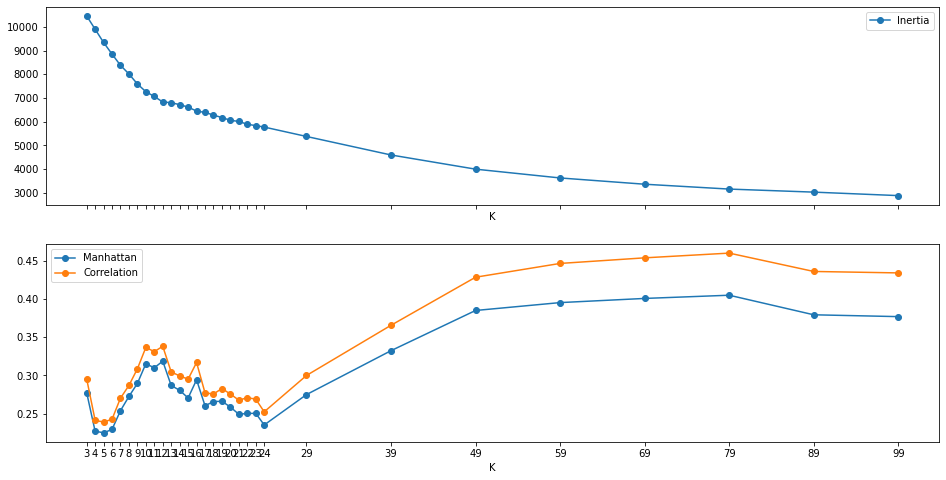

In [15]:
results = dict()
k_cand = list(np.arange(3,25,1))
k_cand.extend(np.arange(29, 100, 10))

for k in k_cand:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(final_df)
    score0 = kmeans.inertia_
    score1 = silhouette_score(final_df,kmeans.labels_,metric='manhattan')
    score2 = silhouette_score(final_df,kmeans.labels_,metric='correlation')
    results[k] = {'k':kmeans,'s0':score0,'s1':score1,'s2':score2}

fig,axs = plt.subplots(2,1,sharex=True,figsize=(16,8))
axs[0].plot([i for i in results.keys()],[i['s0'] for i in results.values()],'o-',label='Inertia')
axs[1].plot([i for i in results.keys()],[i['s1'] for i in results.values()],'o-',label='Manhattan')
axs[1].plot([i for i in results.keys()],[i['s2'] for i in results.values()],'o-',label='Correlation')
for ax in axs:
    ax.set_xticks(k_cand)
    ax.set_xlabel('K')
    ax.legend()


In [16]:
#PLOT CLUSTERS IN T-SNE EMBEDDING
tsne['k'] = results[10]['k'].labels_
tsne.rename(columns={0: "t-SNE 1", 1: "t-SNE 2"}, inplace=True)
#pass to plotly plot to map categorical varibles
tsne['k'] = tsne['k'].astype(str)
tsne['Reaction_Set'] = merged_df['Reaction_Set'].tolist()
tsne['Subsystem'] = merged_df['Subsystem'].tolist()
tsne['Condition'] = condition_column
tsne['Study'] = merged_df['Study'].tolist()

fig = px.scatter(tsne,
                 x="t-SNE 1", y="t-SNE 2",
                 color='k',
                 symbol='Reaction_Set',
                 hover_data=['Subsystem', 'Condition', 'Study'],
                 color_discrete_sequence=px.colors.qualitative.Plotly)

fig.update_layout(plot_bgcolor= 'white',
                  width = 1000,
                  height = 800)

fig.update_traces(marker_size=6)
fig.update_xaxes(showline=True, linewidth=2, linecolor='black')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black')

fig.show()

In [17]:
cluster_rxn_study_dict = {}

for cluster in tsne.k.unique().tolist():
    studies = tsne.loc[tsne['k']==cluster, 'Study'].unique().tolist()
    rxns = tsne.loc[tsne['k']==cluster, 'Reaction_Set'].unique().tolist()
    cluster_rxn_study_dict['_'.join(['cluster', cluster])] = { 'Study' : studies, 'Reaction_Set' : rxns }

cluster_rxn_study_dict

{'cluster_2': {'Study': ['Carbon_Study'], 'Reaction_Set': ['NBR']},
 'cluster_8': {'Study': ['Carbon_Study'], 'Reaction_Set': ['ATP']},
 'cluster_4': {'Study': ['Carbon_Study'], 'Reaction_Set': ['BAR']},
 'cluster_9': {'Study': ['Carbon2_Study'],
  'Reaction_Set': ['NBR', 'ATP', 'BAR']},
 'cluster_1': {'Study': ['Carbon2_Study', 'Muconate_Study'],
  'Reaction_Set': ['ATP']},
 'cluster_3': {'Study': ['Aromatics_Study'], 'Reaction_Set': ['NBR']},
 'cluster_7': {'Study': ['Aromatics_Study'], 'Reaction_Set': ['ATP']},
 'cluster_6': {'Study': ['Aromatics_Study'], 'Reaction_Set': ['BAR']},
 'cluster_0': {'Study': ['Muconate_Study'], 'Reaction_Set': ['NBR']},
 'cluster_5': {'Study': ['Muconate_Study'], 'Reaction_Set': ['BAR']}}

#### K-Prototypes

In [17]:
proto_df = merged_df.copy()
for feature in numerical_features:
    proto_df[feature] = final_df[feature]

display(proto_df)

#ELBOW ANALYSIS TO CHOOSE THE BEST NUMBER OF CLUSTERS
# Initialize an empty list to store WCSS values
wcss = []

# Loop through a range of cluster numbers
for i in range(1, 20):
    kproto = KPrototypes(n_clusters=i, init='Cao')
    kproto.fit_predict(proto_df, categorical=[0,3,4])
    wcss.append(kproto.cost_)


Subsystem       p-Value    recall  \
0                             S_Transport__ABC_system  3.740472e-43  0.503185   
1                         S_Transport__Inner_Membrane  1.097421e-37  0.519380   
2   S_Alternate_Carbon_and_Nitrogen_source__Amines...  9.090321e-27  0.714286   
3                                          Unassigned  2.162676e-17  0.560000   
4                         S_Transport__Outer_Membrane  5.021249e-15  0.611111   
..                                                ...           ...       ...   
83  S_Alternate_Carbon__Ascorbate_and_Aldarate_Met...  1.000000e+00  0.000000   
84                            S_Alginate_biosynthesis  1.000000e+00  0.000000   
85  S_Alternate_Carbon_and_Nitrogen_source__Hydrox...  1.000000e+00  0.000000   
86  S_Aromatic_Compounds_Degradation__Nicotinic_ac...  1.000000e+00  0.000000   
87          S_Alternate_Carbon__Butanediol_Metabolism  1.000000e+00  0.000000   

   Reaction_Set           Study  EX_fru_e  EX_T4hcinnm_e  EX_glc_e  EX_fer_e  \
0           NBR    Carbon_Study  0.000000            0.0  0.000000       0.0   
1           NBR    Carbon_Study  0.000000            0.0  0.000000       0.0   
2           NBR    Carbon_Study  0.000000            0.0  0.000000       0.0   
3           NBR    Carbon_Study  0.000000            0.0  0.000000       0.0   
4           NBR    Carbon_Study  0.000000            0.0  0.000000       0.0   
..          ...             ...       ...            ...       ...       ...   
83          BAR  Muconate_Study  0.333333            0.0  0.333333       0.0   
84          BAR  Muconate_Study  0.333333            0.0  0.333333       0.0   
85          BAR  Muconate_Study  0.333333            0.0  0.333333       0.0   
86          BAR  Muconate_Study  0.333333            0.0  0.333333       0.0   
87          BAR  Muconate_Study  0.333333            0.0  0.333333       0.0   

    EX_ser__L_e  EX_cit_e  EX_glcn_e  
0           0.0       1.0   0.000000  
1           0.0       1.0   0.000000  
2           0.0       1.0   0.000000  
3           0.0       1.0   0.000000  
4           0.0       1.0   0.000000  
..          ...       ...        ...  
83          0.0       0.0   0.333333  
84          0.0       0.0   0.333333  
85          0.0       0.0   0.333333  
86          0.0       0.0   0.333333  
87          0.0       0.0   0.333333  

[4224 rows x 12 columns]

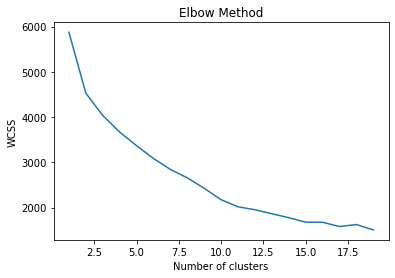

In [18]:
# Plot the WCSS values
plt.plot(range(1, 20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [19]:
#NOW WITH THE BEST ESTIMATED METHOD PLOR CLUSTERS IN T-SNE EMBEDDING
# Perform k-prototypes clustering
kproto = KPrototypes(n_clusters=12, init='Cao')
proto_clusters = kproto.fit_predict(proto_df, categorical=[0,3,4])

tsne['proto_clusters'] = proto_clusters
tsne.rename(columns={0: "t-SNE 1", 1: "t-SNE 2"}, inplace=True)
#pass to plotly plot to map categorical varibles
tsne['proto_clusters'] = tsne['proto_clusters'].astype(str)
tsne['Reaction_Set'] = merged_df['Reaction_Set'].tolist()
tsne['Subsystem'] = merged_df['Subsystem'].tolist()
tsne['Condition'] = condition_column
tsne['Study'] = merged_df['Study'].tolist()

fig = px.scatter(tsne,
                 x="t-SNE 1", y="t-SNE 2",
                 color='proto_clusters',
                 symbol='Reaction_Set',
                 hover_data=['Subsystem', 'Condition', 'Study'],
                 color_discrete_sequence=px.colors.qualitative.Plotly)

fig.update_layout(plot_bgcolor= 'white',
                  width = 1000,
                  height = 800)

fig.update_traces(marker_size=6)
fig.update_xaxes(showline=True, linewidth=2, linecolor='black')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black')

fig.show()


### UMAP embedding

In [20]:
num_clusters = 10
neighbors = 200
distance = 0.99
random_state = 2

umap_embedding = (umap
                  .UMAP(metric='dice', n_neighbors=neighbors, min_dist=distance, n_components=2)
                  .fit_transform(final_df))
                  


/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning:

gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable



#### K-Means

In [21]:
clusters = (KMeans(n_clusters=num_clusters, init='k-means++',
                  verbose=0, random_state=random_state,
                  algorithm='lloyd')
            .fit(umap_embedding)
            .labels_)

plot_data = {'UMAP_1' : umap_embedding[:, 0],
             'UMAP_2' : umap_embedding[:, 1],
             'Cluster' : clusters,
             'Reaction_Set' : merged_df['Reaction_Set'].tolist(),
             'Subsystem' : merged_df['Subsystem'].tolist(),
             'Condition' : condition_column,
             'Study' : merged_df['Study'].tolist()}

umap_df = pd.DataFrame.from_dict(plot_data)
display(umap_df)

UMAP_1     UMAP_2  Cluster Reaction_Set  \
0     46.058453  14.287432        0          NBR   
1     45.780334  14.256193        0          NBR   
2     -8.823423  18.926991        3          NBR   
3    -14.702256   9.034038        3          NBR   
4    -14.672395   9.550506        3          NBR   
...         ...        ...      ...          ...   
4219  25.381277  10.392115        2          BAR   
4220  14.911683   5.214197        2          BAR   
4221  14.922645   5.302536        2          BAR   
4222  11.851837 -11.818649        7          BAR   
4223  23.929562 -10.686558        4          BAR   

                                              Subsystem  \
0                               S_Transport__ABC_system   
1                           S_Transport__Inner_Membrane   
2     S_Alternate_Carbon_and_Nitrogen_source__Amines...   
3                                            Unassigned   
4                           S_Transport__Outer_Membrane   
...                                                 ...   
4219  S_Alternate_Carbon__Ascorbate_and_Aldarate_Met...   
4220                            S_Alginate_biosynthesis   
4221  S_Alternate_Carbon_and_Nitrogen_source__Hydrox...   
4222  S_Aromatic_Compounds_Degradation__Nicotinic_ac...   
4223          S_Alternate_Carbon__Butanediol_Metabolism   

                                       Condition           Study  
0                                m9-EX_cit_e7.44    Carbon_Study  
1                                m9-EX_cit_e7.44    Carbon_Study  
2                                m9-EX_cit_e7.44    Carbon_Study  
3                                m9-EX_cit_e7.44    Carbon_Study  
4                                m9-EX_cit_e7.44    Carbon_Study  
...                                          ...             ...  
4219  m9-EX_glc_e2.48-EX_glcn_e2.48-EX_fru_e0.44  Muconate_Study  
4220  m9-EX_glc_e2.48-EX_glcn_e2.48-EX_fru_e0.44  Muconate_Study  
4221  m9-EX_glc_e2.48-EX_glcn_e2.48-EX_fru_e0.44  Muconate_Study  
4222  m9-EX_glc_e2.48-EX_glcn_e2.48-EX_fru_e0.44  Muconate_Study  
4223  m9-EX_glc_e2.48-EX_glcn_e2.48-EX_fru_e0.44  Muconate_Study  

[4224 rows x 7 columns]

In [22]:
umap_df["Cluster"] = umap_df["Cluster"].astype(str)

fig = px.scatter(umap_df,
                 x="UMAP_1", y="UMAP_2",
                 color='Cluster',
                 symbol='Reaction_Set',
                 hover_data=['Subsystem', 'Condition'],
                 color_discrete_sequence=px.colors.qualitative.Dark24)

fig.update_layout(plot_bgcolor= 'white',
                  width = 1000,
                  height = 800)

fig.update_traces(marker_size=6)
fig.update_xaxes(showline=True, linewidth=2, linecolor='black')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black')

fig.show()

#### K-Prototypes

In [23]:
plot_data = {'UMAP_1' : umap_embedding[:, 0],
             'UMAP_2' : umap_embedding[:, 1],
             'Cluster' : proto_clusters,
             'Reaction_Set' : merged_df['Reaction_Set'].tolist(),
             'Subsystem' : merged_df['Subsystem'].tolist(),
             'Condition' : condition_column,
             'Study' : merged_df['Study'].tolist()}

umap_df = pd.DataFrame.from_dict(plot_data)
display(umap_df)

UMAP_1     UMAP_2  Cluster Reaction_Set  \
0     46.058453  14.287432        4          NBR   
1     45.780334  14.256193        4          NBR   
2     -8.823423  18.926991        4          NBR   
3    -14.702256   9.034038        4          NBR   
4    -14.672395   9.550506        4          NBR   
...         ...        ...      ...          ...   
4219  25.381277  10.392115        1          BAR   
4220  14.911683   5.214197        1          BAR   
4221  14.922645   5.302536        1          BAR   
4222  11.851837 -11.818649        1          BAR   
4223  23.929562 -10.686558        1          BAR   

                                              Subsystem  \
0                               S_Transport__ABC_system   
1                           S_Transport__Inner_Membrane   
2     S_Alternate_Carbon_and_Nitrogen_source__Amines...   
3                                            Unassigned   
4                           S_Transport__Outer_Membrane   
...                                                 ...   
4219  S_Alternate_Carbon__Ascorbate_and_Aldarate_Met...   
4220                            S_Alginate_biosynthesis   
4221  S_Alternate_Carbon_and_Nitrogen_source__Hydrox...   
4222  S_Aromatic_Compounds_Degradation__Nicotinic_ac...   
4223          S_Alternate_Carbon__Butanediol_Metabolism   

                                       Condition           Study  
0                                m9-EX_cit_e7.44    Carbon_Study  
1                                m9-EX_cit_e7.44    Carbon_Study  
2                                m9-EX_cit_e7.44    Carbon_Study  
3                                m9-EX_cit_e7.44    Carbon_Study  
4                                m9-EX_cit_e7.44    Carbon_Study  
...                                          ...             ...  
4219  m9-EX_glc_e2.48-EX_glcn_e2.48-EX_fru_e0.44  Muconate_Study  
4220  m9-EX_glc_e2.48-EX_glcn_e2.48-EX_fru_e0.44  Muconate_Study  
4221  m9-EX_glc_e2.48-EX_glcn_e2.48-EX_fru_e0.44  Muconate_Study  
4222  m9-EX_glc_e2.48-EX_glcn_e2.48-EX_fru_e0.44  Muconate_Study  
4223  m9-EX_glc_e2.48-EX_glcn_e2.48-EX_fru_e0.44  Muconate_Study  

[4224 rows x 7 columns]

In [24]:
umap_df["Cluster"] = umap_df["Cluster"].astype(str)

fig = px.scatter(umap_df,
                 x="UMAP_1", y="UMAP_2",
                 color='Cluster',
                 symbol='Reaction_Set',
                 hover_data=['Subsystem', 'Condition'],
                 color_discrete_sequence=px.colors.qualitative.Dark24)

fig.update_layout(plot_bgcolor= 'white',
                  width = 1000,
                  height = 800)

fig.update_traces(marker_size=6)
fig.update_xaxes(showline=True, linewidth=2, linecolor='black')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black')

fig.show()

## Without feature 'Reaction_Set'

#### Dataframes

In [18]:
#generate final_df without 'Reaction_Set' features
reaction_set_feature_list = ['Reaction_Set_ATP', 'Reaction_Set_BAR', 'Reaction_Set_NBR']
final_df = final_df.drop(columns=reaction_set_feature_list)
display(final_df)
#generate proto_df without 'Reaction_Set' feature
proto_df = merged_df.copy()
for feature in numerical_features:
    proto_df[feature] = final_df[feature]

#remove 'Reaction_Set'
proto_df = proto_df.drop(columns=['Reaction_Set'])
display(proto_df)


p-Value    recall  EX_fru_e  EX_glcn_e  EX_glc_e  EX_T4hcinnm_e  \
0   3.740472e-43  0.503185  0.000000   0.000000  0.000000            0.0   
1   1.097421e-37  0.519380  0.000000   0.000000  0.000000            0.0   
2   9.090321e-27  0.714286  0.000000   0.000000  0.000000            0.0   
3   2.162676e-17  0.560000  0.000000   0.000000  0.000000            0.0   
4   5.021249e-15  0.611111  0.000000   0.000000  0.000000            0.0   
..           ...       ...       ...        ...       ...            ...   
83  1.000000e+00  0.000000  0.333333   0.333333  0.333333            0.0   
84  1.000000e+00  0.000000  0.333333   0.333333  0.333333            0.0   
85  1.000000e+00  0.000000  0.333333   0.333333  0.333333            0.0   
86  1.000000e+00  0.000000  0.333333   0.333333  0.333333            0.0   
87  1.000000e+00  0.000000  0.333333   0.333333  0.333333            0.0   

    EX_fer_e  EX_ser__L_e  EX_cit_e  col_0  col_1  col_2  col_3  col_4  col_5  \
0        0.0          0.0       1.0      0      0      0      0      1      0   
1        0.0          0.0       1.0      0      0      0      0      1      0   
2        0.0          0.0       1.0      0      0      0      0      0      0   
3        0.0          0.0       1.0      0      0      0      0      0      1   
4        0.0          0.0       1.0      0      0      0      0      0      1   
..       ...          ...       ...    ...    ...    ...    ...    ...    ...   
83       0.0          0.0       0.0      1      0      0      0      0      0   
84       0.0          0.0       0.0      0      0      1      0      0      0   
85       0.0          0.0       0.0      0      0      1      0      0      0   
86       0.0          0.0       0.0      0      1      0      0      0      0   
87       0.0          0.0       0.0      0      0      0      0      0      1   

    col_6  Study_Carbon_Study  Study_Carbon2_Study  Study_Aromatics_Study  \
0       0                 1.0                  0.0                    0.0   
1       0                 1.0                  0.0                    0.0   
2       1                 1.0                  0.0                    0.0   
3       0                 1.0                  0.0                    0.0   
4       0                 1.0                  0.0                    0.0   
..    ...                 ...                  ...                    ...   
83      0                 0.0                  0.0                    0.0   
84      0                 0.0                  0.0                    0.0   
85      0                 0.0                  0.0                    0.0   
86      0                 0.0                  0.0                    0.0   
87      0                 0.0                  0.0                    0.0   

    Study_Muconate_Study  
0                    0.0  
1                    0.0  
2                    0.0  
3                    0.0  
4                    0.0  
..                   ...  
83                   1.0  
84                   1.0  
85                   1.0  
86                   1.0  
87                   1.0  

[4224 rows x 20 columns]

Subsystem       p-Value    recall  \
0                             S_Transport__ABC_system  3.740472e-43  0.503185   
1                         S_Transport__Inner_Membrane  1.097421e-37  0.519380   
2   S_Alternate_Carbon_and_Nitrogen_source__Amines...  9.090321e-27  0.714286   
3                                          Unassigned  2.162676e-17  0.560000   
4                         S_Transport__Outer_Membrane  5.021249e-15  0.611111   
..                                                ...           ...       ...   
83  S_Alternate_Carbon__Ascorbate_and_Aldarate_Met...  1.000000e+00  0.000000   
84                            S_Alginate_biosynthesis  1.000000e+00  0.000000   
85  S_Alternate_Carbon_and_Nitrogen_source__Hydrox...  1.000000e+00  0.000000   
86  S_Aromatic_Compounds_Degradation__Nicotinic_ac...  1.000000e+00  0.000000   
87          S_Alternate_Carbon__Butanediol_Metabolism  1.000000e+00  0.000000   

             Study  EX_T4hcinnm_e  EX_glcn_e  EX_fer_e  EX_fru_e  EX_glc_e  \
0     Carbon_Study            0.0   0.000000       0.0  0.000000  0.000000   
1     Carbon_Study            0.0   0.000000       0.0  0.000000  0.000000   
2     Carbon_Study            0.0   0.000000       0.0  0.000000  0.000000   
3     Carbon_Study            0.0   0.000000       0.0  0.000000  0.000000   
4     Carbon_Study            0.0   0.000000       0.0  0.000000  0.000000   
..             ...            ...        ...       ...       ...       ...   
83  Muconate_Study            0.0   0.333333       0.0  0.333333  0.333333   
84  Muconate_Study            0.0   0.333333       0.0  0.333333  0.333333   
85  Muconate_Study            0.0   0.333333       0.0  0.333333  0.333333   
86  Muconate_Study            0.0   0.333333       0.0  0.333333  0.333333   
87  Muconate_Study            0.0   0.333333       0.0  0.333333  0.333333   

    EX_ser__L_e  EX_cit_e  
0           0.0       1.0  
1           0.0       1.0  
2           0.0       1.0  
3           0.0       1.0  
4           0.0       1.0  
..          ...       ...  
83          0.0       0.0  
84          0.0       0.0  
85          0.0       0.0  
86          0.0       0.0  
87          0.0       0.0  

[4224 rows x 11 columns]

### t-SNE embedding

In [21]:
tsne_model = TSNE(n_components=2, perplexity=2000, init='pca', verbose=1, random_state=2, n_iter=500)
tsne = tsne_model.fit_transform(final_df)
tsne = pd.DataFrame(tsne)

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 4223 nearest neighbors...
[t-SNE] Indexed 4224 samples in 0.001s...
[t-SNE] Computed neighbors for 4224 samples in 0.922s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4224
[t-SNE] Computed conditional probabilities for sample 2000 / 4224
[t-SNE] Computed conditional probabilities for sample 3000 / 4224
[t-SNE] Computed conditional probabilities for sample 4000 / 4224
[t-SNE] Computed conditional probabilities for sample 4224 / 4224
[t-SNE] Mean sigma: 1.200670


/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



[t-SNE] KL divergence after 100 iterations with early exaggeration: 38.586540
[t-SNE] KL divergence after 500 iterations: 0.283772


#### K-means

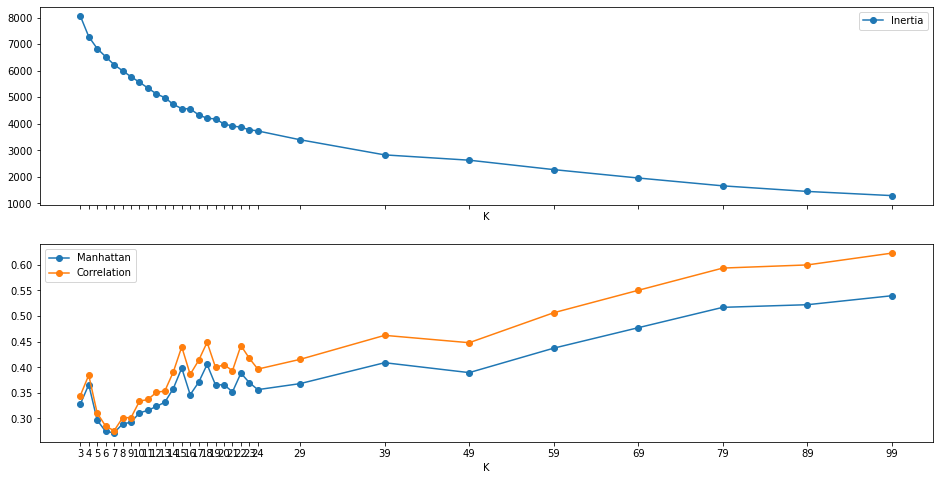

In [22]:
results = dict()
k_cand = list(np.arange(3,25,1))
k_cand.extend(np.arange(29, 100, 10))


for k in k_cand:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(final_df)
    score0 = kmeans.inertia_
    score1 = silhouette_score(final_df,kmeans.labels_,metric='manhattan')
    score2 = silhouette_score(final_df,kmeans.labels_,metric='correlation')
    results[k] = {'k':kmeans,'s0':score0,'s1':score1,'s2':score2}

fig,axs = plt.subplots(2,1,sharex=True,figsize=(16,8))
axs[0].plot([i for i in results.keys()],[i['s0'] for i in results.values()],'o-',label='Inertia')
axs[1].plot([i for i in results.keys()],[i['s1'] for i in results.values()],'o-',label='Manhattan')
axs[1].plot([i for i in results.keys()],[i['s2'] for i in results.values()],'o-',label='Correlation')
for ax in axs:
    ax.set_xticks(k_cand)
    ax.set_xlabel('K')
    ax.legend()

In [23]:
#PLOT CLUSTERS IN T-SNE EMBEDDING
tsne['k'] = results[18]['k'].labels_
tsne.rename(columns={0: "t-SNE 1", 1: "t-SNE 2"}, inplace=True)
#pass to plotly plot to map categorical varibles
tsne['k'] = tsne['k'].astype(str)
tsne['Reaction_Set'] = merged_df['Reaction_Set'].tolist()
tsne['Subsystem'] = merged_df['Subsystem'].tolist()
tsne['Condition'] = condition_column
tsne['Study'] = merged_df['Study'].tolist()

fig = px.scatter(tsne,
                 x="t-SNE 1", y="t-SNE 2",
                 color='k',
                 symbol='Reaction_Set',
                 hover_data=['Subsystem', 'Condition', 'Study'],
                 color_discrete_sequence=px.colors.qualitative.Dark24)

fig.update_layout(plot_bgcolor= 'white',
                  width = 1000,
                  height = 800)

fig.update_traces(marker_size=6)
fig.update_xaxes(showline=True, linewidth=2, linecolor='black')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black')

fig.show()

#### K-Prototypes

In [38]:
#ELBOW ANALYSIS TO CHOOSE THE BEST NUMBER OF CLUSTERS
# Initialize an empty list to store WCSS values
wcss = []

# Loop through a range of cluster numbers
for i in range(8, 15):
    kproto = KPrototypes(n_clusters=i, init='Cao')
    kproto.fit_predict(proto_df, categorical=[0,3])
    wcss.append(kproto.cost_)

Subsystem       p-Value    recall  \
0                             S_Transport__ABC_system  3.740472e-43  0.503185   
1                         S_Transport__Inner_Membrane  1.097421e-37  0.519380   
2   S_Alternate_Carbon_and_Nitrogen_source__Amines...  9.090321e-27  0.714286   
3                                          Unassigned  2.162676e-17  0.560000   
4                         S_Transport__Outer_Membrane  5.021249e-15  0.611111   
..                                                ...           ...       ...   
83  S_Alternate_Carbon__Ascorbate_and_Aldarate_Met...  1.000000e+00  0.000000   
84                            S_Alginate_biosynthesis  1.000000e+00  0.000000   
85  S_Alternate_Carbon_and_Nitrogen_source__Hydrox...  1.000000e+00  0.000000   
86  S_Aromatic_Compounds_Degradation__Nicotinic_ac...  1.000000e+00  0.000000   
87          S_Alternate_Carbon__Butanediol_Metabolism  1.000000e+00  0.000000   

             Study  EX_fru_e  EX_T4hcinnm_e  EX_glc_e  EX_fer_e  EX_ser__L_e  \
0     Carbon_Study  0.000000            0.0  0.000000       0.0          0.0   
1     Carbon_Study  0.000000            0.0  0.000000       0.0          0.0   
2     Carbon_Study  0.000000            0.0  0.000000       0.0          0.0   
3     Carbon_Study  0.000000            0.0  0.000000       0.0          0.0   
4     Carbon_Study  0.000000            0.0  0.000000       0.0          0.0   
..             ...       ...            ...       ...       ...          ...   
83  Muconate_Study  0.333333            0.0  0.333333       0.0          0.0   
84  Muconate_Study  0.333333            0.0  0.333333       0.0          0.0   
85  Muconate_Study  0.333333            0.0  0.333333       0.0          0.0   
86  Muconate_Study  0.333333            0.0  0.333333       0.0          0.0   
87  Muconate_Study  0.333333            0.0  0.333333       0.0          0.0   

    EX_cit_e  EX_glcn_e  
0        1.0   0.000000  
1        1.0   0.000000  
2        1.0   0.000000  
3        1.0   0.000000  
4        1.0   0.000000  
..       ...        ...  
83       0.0   0.333333  
84       0.0   0.333333  
85       0.0   0.333333  
86       0.0   0.333333  
87       0.0   0.333333  

[4224 rows x 11 columns]

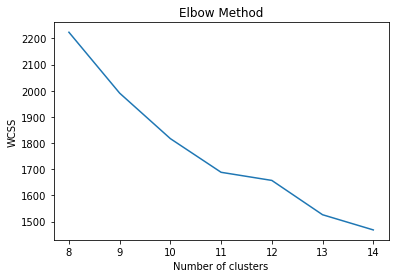

In [39]:
# Plot the WCSS values
plt.plot(range(8, 15), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [24]:
#NOW WITH THE BEST ESTIMATED METHOD PLOR CLUSTERS IN T-SNE EMBEDDING
# Perform k-prototypes clustering
kproto = KPrototypes(n_clusters=11, init='Cao')
proto_clusters = kproto.fit_predict(proto_df, categorical=[0,3,4])

tsne['proto_clusters'] = proto_clusters
tsne.rename(columns={0: "t-SNE 1", 1: "t-SNE 2"}, inplace=True)
#pass to plotly plot to map categorical varibles
tsne['proto_clusters'] = tsne['proto_clusters'].astype(str)
tsne['Reaction_Set'] = merged_df['Reaction_Set'].tolist()
tsne['Subsystem'] = merged_df['Subsystem'].tolist()
tsne['Condition'] = condition_column
tsne['Study'] = merged_df['Study'].tolist()

fig = px.scatter(tsne,
                 x="t-SNE 1", y="t-SNE 2",
                 color='proto_clusters',
                 symbol='Reaction_Set',
                 hover_data=['Subsystem', 'Condition', 'Study'],
                 color_discrete_sequence=px.colors.qualitative.Plotly)

fig.update_layout(plot_bgcolor= 'white',
                  width = 1000,
                  height = 800)

fig.update_traces(marker_size=6)
fig.update_xaxes(showline=True, linewidth=2, linecolor='black')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black')

fig.show()

### UMAP embedding

#### K-Means

In [50]:
num_clusters = 18
neighbors = 200
distance = 0.99
random_state = 0

umap_embedding = (umap
                  .UMAP(metric='dice', n_neighbors=neighbors, min_dist=distance, n_components=2)
                  .fit_transform(final_df))

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning:

gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable



In [51]:
clusters = (KMeans(n_clusters=num_clusters, init='k-means++',
                  verbose=0, random_state=random_state,
                  algorithm='lloyd')
            .fit(umap_embedding)
            .labels_)

plot_data = {'UMAP_1' : umap_embedding[:, 0],
             'UMAP_2' : umap_embedding[:, 1],
             'Cluster' : clusters,
             'Reaction_Set' : merged_df['Reaction_Set'].tolist(),
             'Subsystem' : merged_df['Subsystem'].tolist(),
             'Condition' : condition_column,
             'Study' : merged_df['Study'].tolist()}

umap_df = pd.DataFrame.from_dict(plot_data)
display(umap_df)

UMAP_1     UMAP_2  Cluster Reaction_Set  \
0     -8.575149   3.358659        4          NBR   
1     -8.162232   3.652551        4          NBR   
2    -19.167727  -1.569287        8          NBR   
3     -9.192006 -23.844572        2          NBR   
4     -9.033258 -24.229904        2          NBR   
...         ...        ...      ...          ...   
4219   9.264021 -25.852491        7          BAR   
4220  15.374559 -23.167858        7          BAR   
4221  15.463954 -22.958052        7          BAR   
4222  27.962246   9.979544        9          BAR   
4223  -2.367103 -22.482571        2          BAR   

                                              Subsystem  \
0                               S_Transport__ABC_system   
1                           S_Transport__Inner_Membrane   
2     S_Alternate_Carbon_and_Nitrogen_source__Amines...   
3                                            Unassigned   
4                           S_Transport__Outer_Membrane   
...                                                 ...   
4219  S_Alternate_Carbon__Ascorbate_and_Aldarate_Met...   
4220                            S_Alginate_biosynthesis   
4221  S_Alternate_Carbon_and_Nitrogen_source__Hydrox...   
4222  S_Aromatic_Compounds_Degradation__Nicotinic_ac...   
4223          S_Alternate_Carbon__Butanediol_Metabolism   

                                       Condition           Study  
0                                m9-EX_cit_e7.44    Carbon_Study  
1                                m9-EX_cit_e7.44    Carbon_Study  
2                                m9-EX_cit_e7.44    Carbon_Study  
3                                m9-EX_cit_e7.44    Carbon_Study  
4                                m9-EX_cit_e7.44    Carbon_Study  
...                                          ...             ...  
4219  m9-EX_glc_e2.48-EX_glcn_e2.48-EX_fru_e0.44  Muconate_Study  
4220  m9-EX_glc_e2.48-EX_glcn_e2.48-EX_fru_e0.44  Muconate_Study  
4221  m9-EX_glc_e2.48-EX_glcn_e2.48-EX_fru_e0.44  Muconate_Study  
4222  m9-EX_glc_e2.48-EX_glcn_e2.48-EX_fru_e0.44  Muconate_Study  
4223  m9-EX_glc_e2.48-EX_glcn_e2.48-EX_fru_e0.44  Muconate_Study  

[4224 rows x 7 columns]

In [52]:
umap_df["Cluster"] = umap_df["Cluster"].astype(str)

fig = px.scatter(umap_df,
                 x="UMAP_1", y="UMAP_2",
                 color='Cluster',
                 symbol='Reaction_Set',
                 hover_data=['Subsystem', 'Condition', 'Study'],
                 color_discrete_sequence=px.colors.qualitative.Dark24)

fig.update_layout(plot_bgcolor= 'white',
                  width = 1000,
                  height = 800)

fig.update_traces(marker_size=6)
fig.update_xaxes(showline=True, linewidth=2, linecolor='black')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black')

fig.show()

#### K-Prototypes

In [56]:
num_clusters = 11
neighbors = 200
distance = 0.99
random_state = 0

umap_embedding = (umap
                  .UMAP(metric='dice', n_neighbors=neighbors, min_dist=distance, n_components=2)
                  .fit_transform(final_df))

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning:

gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable



In [57]:
plot_data = {'UMAP_1' : umap_embedding[:, 0],
             'UMAP_2' : umap_embedding[:, 1],
             'Cluster' : proto_clusters,
             'Reaction_Set' : merged_df['Reaction_Set'].tolist(),
             'Subsystem' : merged_df['Subsystem'].tolist(),
             'Condition' : condition_column,
             'Study' : merged_df['Study'].tolist()}

umap_df = pd.DataFrame.from_dict(plot_data)
display(umap_df)

UMAP_1     UMAP_2  Cluster Reaction_Set  \
0     -8.584182 -14.686717        2          NBR   
1     -8.877442 -15.198956        2          NBR   
2    -11.986069   1.816418        2          NBR   
3    -16.845327 -21.311533        2          NBR   
4    -16.979553 -21.388212        2          NBR   
...         ...        ...      ...          ...   
4219  11.355104 -17.630346        7          BAR   
4220  21.758940  -4.885951        7          BAR   
4221  21.780848  -4.808006        7          BAR   
4222  32.843197   0.115272        7          BAR   
4223  22.642941 -31.981300        7          BAR   

                                              Subsystem  \
0                               S_Transport__ABC_system   
1                           S_Transport__Inner_Membrane   
2     S_Alternate_Carbon_and_Nitrogen_source__Amines...   
3                                            Unassigned   
4                           S_Transport__Outer_Membrane   
...                                                 ...   
4219  S_Alternate_Carbon__Ascorbate_and_Aldarate_Met...   
4220                            S_Alginate_biosynthesis   
4221  S_Alternate_Carbon_and_Nitrogen_source__Hydrox...   
4222  S_Aromatic_Compounds_Degradation__Nicotinic_ac...   
4223          S_Alternate_Carbon__Butanediol_Metabolism   

                                       Condition           Study  
0                                m9-EX_cit_e7.44    Carbon_Study  
1                                m9-EX_cit_e7.44    Carbon_Study  
2                                m9-EX_cit_e7.44    Carbon_Study  
3                                m9-EX_cit_e7.44    Carbon_Study  
4                                m9-EX_cit_e7.44    Carbon_Study  
...                                          ...             ...  
4219  m9-EX_glc_e2.48-EX_glcn_e2.48-EX_fru_e0.44  Muconate_Study  
4220  m9-EX_glc_e2.48-EX_glcn_e2.48-EX_fru_e0.44  Muconate_Study  
4221  m9-EX_glc_e2.48-EX_glcn_e2.48-EX_fru_e0.44  Muconate_Study  
4222  m9-EX_glc_e2.48-EX_glcn_e2.48-EX_fru_e0.44  Muconate_Study  
4223  m9-EX_glc_e2.48-EX_glcn_e2.48-EX_fru_e0.44  Muconate_Study  

[4224 rows x 7 columns]

In [59]:
umap_df["Cluster"] = umap_df["Cluster"].astype(str)

fig = px.scatter(umap_df,
                 x="UMAP_1", y="UMAP_2",
                 color='Cluster',
                 symbol='Reaction_Set',
                 hover_data=['Subsystem', 'Condition', 'Study'],
                 color_discrete_sequence=px.colors.qualitative.Dark24)

fig.update_layout(plot_bgcolor= 'white',
                  width = 1000,
                  height = 800)

fig.update_traces(marker_size=6)
fig.update_xaxes(showline=True, linewidth=2, linecolor='black')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black')

fig.show()